# 멋진 작사가 만들기
---
노래 가사 데이터를 학습하여 노래 가사를 생성하는 작문 인공지능을 구축해본다.

## STEP0. 설계
--- 
노래 가사를 만드는 작사가 모델을 구축하기 위하여 다음과 같은 순서로 프로젝트를 진행 할 것이다.

1. 자료수집 : 모델 학습에 필요한 가사 데이터를 수집한다.
2. 데이터 전처리 : 1에서 수집한 데이터를 읽어들여 모델에 학습시키기 적합한 형태로 가공한다.
    - 필터링 : 문장에 불필요한 정보가 없는지 확인하고 이를 삭제한다.
    - 데이터 정제
        - 문장의 전후에 `<start>`와 `<end>` 추가
        - 불필요한 특수문자 제거 : 노래가사에는 `.`, `,`, `?`, `!`을 제외한 특수문자가 필요하지 않을 것이다.
        - 지나치게 긴 문장
            - 다른 데이터들이 과도한 Padding을 갖게 하므로 제거한다.
            - 이번 프로젝트에서는 문장을 토큰화 했을 때 토큰의 개수가 15개 이상이 되는 문장은 학습데이터에서 제외하기를 권장된다.
    - 토큰화
        - 공백을 기준으로 문장을 토큰화한다.
    - 소스와 타겟 데이터 분리 및 데이터셋 생성
        - 단어장의 크기는 12,000 이상이 권장된다.
        - 전체 데이터에 대한 타겟 데이터의 비율은 20%가 되도록 설정한다.
3. 모델 학습 및 평가
    - 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하라.
    - 학습된 모델을 활용하여 가사를 생성해보자✊

## STEP1. 자료수집
---

- kaggle에서 제공하는 노래가사 자료를 다운로드 받는다.

In [1]:
# !wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip -P ./data

In [2]:
# !unzip ./data/song_lyrics.zip -d ./data/lyrics 

데이터를 성공적으로 다운로드 받았다😎

## STEP2. 데이터 전처리
---

In [1]:
%config Completer.use_jedi = False
%load_ext autotime

import os, re, glob
import tensorflow as tf 
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import pandas as pd

time: 1.64 s (started: 2021-02-02 20:56:18 +09:00)


In [2]:
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e, "\n\n")

time: 777 µs (started: 2021-02-02 20:56:20 +09:00)


In [3]:
WORKSPACE_PATH = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E06_lyricist'
init_gpu()

1 Physical GPUs, 1 Logical GPUs


time: 147 ms (started: 2021-02-02 20:56:20 +09:00)


### 데이터 읽어오기

In [4]:
def load_sentences(path):
    txt_list = glob.glob(path)
    raw_corpus = []

    # 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
    for txt_file in txt_list:
        with open(txt_file, "r") as f:
            raw = f.read().splitlines()
            raw_corpus.extend(raw)

    return raw_corpus

time: 1.47 ms (started: 2021-02-02 20:56:22 +09:00)


In [5]:
raw_corpus = load_sentences(WORKSPACE_PATH + '/data/lyrics/*')
print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['I bought my first key from my baby momma brother', 'I bought my first key', 'Bought my bought my first key']
time: 45.9 ms (started: 2021-02-02 20:56:23 +09:00)


### 필터링
- 데이터를 확인하였을 때, 직관적으로 확인할 수 있는 제거 가능한 정보에는 공백으로만 이루어진 문장('')과 중복되는 문장이 있다.

In [61]:
print("1) " + raw_corpus[91])
print("2-1) " + raw_corpus[49], raw_corpus[50])
print("2-2) " + raw_corpus[54], raw_corpus[55])
print("3-1) " + raw_corpus[378])
print("3-2) " + raw_corpus[379])
print("3-3) " + raw_corpus[380])

1) 
2-1) I bought my first key from my baby momma brother cooked it up myself and started
2-2) I bought my first key from my baby momma brother cooked it up myself and started
3-1) The best rapper alive huh yup
3-2) The best rapper alive huh yup
3-3) The best rapper alive huh yup
time: 2.74 ms (started: 2021-02-02 20:21:50 +09:00)


- filtering 함수를 이용하여 불필요한 데이터 제거

In [1]:
def filtering(sentences):
    blank_removed_sentences = [ s for s in sentences if len(s) > 0 and s != ' ' ]    
    duplication_removed_sentences = list(set(blank_removed_sentences))    
    
    print(f'[sentence amount] before filtering : {len(sentences)}')
    print(f'[sentence amount] after remove blank : {len(blank_removed_sentences)}')
    print(f'[sentence amount] after remove duplication : {len(duplication_removed_sentences)}\n\n')
    
    return duplication_removed_sentences

In [63]:
raw_corpus = filtering(raw_corpus)

[sentence amount] before filtering : 187088
[sentence amount] after remove blank : 175961
[sentence amount] after remove duplication : 118166


time: 67.6 ms (started: 2021-02-02 20:21:55 +09:00)


### 데이터 정제

- 문장의 전후에 <start>와 <end> 추가
- 불필요한 특수문자 제거 : 노래가사에는 `.`, `,`, `?`, `!`을 제외한 특수문자가 필요하지 않을 것이다.

In [36]:
def preprocess_sentences(raw_corpus):
    def preprocess_sentence(sentence):
        # 소문자로 바꾸고 양쪽 공백을 삭제
        sentence = sentence.lower().strip()

        # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
        # 1. 패턴의 특수문자(.,?!)를 만나면 특수문자 양쪽에 공백을 추가
        # 2. 공백 패턴을 만나면 스페이스 1개로 치환
        # 3. a-zA-Z?.!,' 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,?]+", " ", sentence)
        sentence = sentence.strip()

        # 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
        sentence = '<start> ' + sentence + ' <end>'      
        return sentence
    
    raw_corpus = [ preprocess_sentence(s) for s in raw_corpus ]
    corpus = [ c for c in raw_corpus if c.count(" ") < 14 ]
    return corpus

print(f"[preprocess] before : {[raw_corpus[10]]}")
print(f"[preprocess] after  : {preprocess_sentences([raw_corpus[10]])}")

[preprocess] before : ['We on the grind and our nuts got bigga']
[preprocess] after  : ['<start> we on the grind and our nuts got bigga <end>']
time: 2.62 ms (started: 2021-02-02 21:06:06 +09:00)


In [73]:
print(f'[sentence amount] before preprocessing : {len(raw_corpus)}')
corpus = preprocess_sentences(raw_corpus)
print(f'[sentence amount] before preprocessing : {len(corpus)}')

[sentence amount] before preprocessing : 118166
[sentence amount] before preprocessing : 97749
time: 1.24 s (started: 2021-02-02 20:22:18 +09:00)


- 데이터를 재사용할 가능성이 높으므로 가공된 데이터를 텍스트 파일로 저장해 놓도록 한다.

In [66]:
def save_sentences(sentences):
    txt = "\n".join(sentences)
    with open(WORKSPACE_PATH + '/data/preprocessed_sentences.txt', 'w') as f:
        f.write(txt)
        
save_sentences(corpus)

time: 19.8 ms (started: 2021-02-02 20:22:00 +09:00)


In [67]:
# 저장된 텍스트 파일 확인
!head ./data/preprocessed_sentences.txt --lines=5 

<start> you know , i caught her messing around with another man <end>
<start> then we get it on <end>
<start> cause i gotta be up at <end>
<start> and the melody that he gave to me <end>
<start> don t alarm em <end>
time: 183 ms (started: 2021-02-02 20:22:03 +09:00)


### 토큰화

- `tf.keras.preprocessing.text.Tokenizer`를 이용하여 토큰화를 진행한다.
- 이때, 전체 단어의 수를 12000으로 설정해주었다.

In [6]:
# load corpus from file
with open(WORKSPACE_PATH + '/data/preprocessed_sentences.txt', 'r') as f:
    data = f.read()
    corpus = data.split('\n')
corpus[:5]

['<start> you know , i caught her messing around with another man <end>',
 '<start> then we get it on <end>',
 '<start> cause i gotta be up at <end>',
 '<start> and the melody that he gave to me <end>',
 '<start> don t alarm em <end>']

time: 32.3 ms (started: 2021-02-02 20:56:30 +09:00)


In [7]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',      # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=15, padding='post')  

    return tensor, tokenizer

time: 736 µs (started: 2021-02-02 20:56:31 +09:00)


In [8]:
tensor, tokenizer = tokenize(corpus)
vocab_size = tokenizer.num_words + 1

time: 1.9 s (started: 2021-02-02 20:56:31 +09:00)


In [9]:
print(type(tensor))
print(tensor.shape)
print(tensor[:3, :10])

<class 'numpy.ndarray'>
(97749, 15)
[[   2    7   35    4    5  623   63 2950  129   29]
 [   2   87   22   47   11   20    3    0    0    0]
 [   2   70    5  149   27   32   66    3    0    0]]
time: 640 µs (started: 2021-02-02 20:56:33 +09:00)


In [10]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
time: 872 µs (started: 2021-02-02 20:56:33 +09:00)


### 소스와 타겟 데이터 분리 및 데이터셋 생성

In [11]:
def get_dataset(tensor, BATCH_SIZE):
    # 1. 생성된 텐서를 소스와 타겟으로 분리
    # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
    src_input = tensor[:, :-1]
    tgt_input = tensor[:, 1:] 
    
    # 2. 데이터 분리
    enc_train, enc_test, dec_train, dec_test = train_test_split(src_input, 
                                                                tgt_input,
                                                                test_size=0.2,
                                                                random_state=50)
    print("Source Train:", enc_train.shape)
    print("Target Train:", dec_train.shape)
    print("Source Validation:", enc_test.shape)
    print("Target Validation:", dec_test.shape)
    
    # 3. 데이터셋 객체 생성
    BUFFER_SIZE = len(enc_train)
    steps_per_epoch = len(enc_train) // BATCH_SIZE
    
    train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

    test_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test)).shuffle(BUFFER_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

    return train_dataset, test_dataset

time: 2.55 ms (started: 2021-02-02 20:56:35 +09:00)


In [12]:
train_dataset, test_dataset = get_dataset(tensor, 256) 

Source Train: (78199, 14)
Target Train: (78199, 14)
Source Validation: (19550, 14)
Target Validation: (19550, 14)
time: 29.6 ms (started: 2021-02-02 20:56:35 +09:00)


## STEP3. 모델 학습 및 평가
---

### 모델 설계

- `get_model` 함수에서 반환되는 모델은 다음과 같은 특징을 가질 수 있다.
    - {num_of_layer-2} layer network : 파라미터에 의해 LSTM 레이어가 몇층으로 이루어질지를 구성 할 수 있다.
    - 학습 된 word2vec 사용 : 외부에서 사전 학습된 word2vec를 활용하여 Embedding 레이어를 구성할 수 있다.

In [13]:
def get_model(vocab_size, embedding_size, hidden_size, num_of_layer, embedding_matrix=None):
    model = tf.keras.Sequential()
    
    if embedding_matrix == None:
        model.add(tf.keras.layers.Embedding(vocab_size, embedding_size))
    else :
        model.add(tf.keras.layers.Embedding(vocab_size, embedding_size,
                                            embeddings_initializer=Constant(embedding_matrix),
                                            trainable=True))
    for _ in range(num_of_layer - 2): 
        model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

time: 1.95 ms (started: 2021-02-02 20:56:39 +09:00)


In [14]:
def build_model(model, sample):
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                         reduction='none')
        
    model.compile(loss=loss, optimizer=optimizer)
    model(sample)
    model.summary()

time: 1.64 ms (started: 2021-02-02 20:56:40 +09:00)


#### 모델생성

- 하이퍼 파라미터 설정

In [15]:
steps = [32, 64, 128, 256, 512, 1024]
#  (embedding_size, hidden_size )
hyper_parms = [ (i, j) for i in steps for j in steps ]

time: 1.42 ms (started: 2021-02-02 20:56:43 +09:00)


In [16]:
# 빌드용 sample 데이터 
for input_sample, output_sample in train_dataset.take(1): break
    
init_gpu()

1 Physical GPUs, 1 Logical GPUs


time: 121 ms (started: 2021-02-02 20:56:43 +09:00)


In [17]:
get_model_name = lambda l, hp : f'l_{l}_b_256_e_{hp[0]}_h_{hp[1]}'
get_model_path = lambda l, hp : f'{WORKSPACE_PATH}/models/layer_{l}/l_{l}_b_256_e_{hp[0]}_h_{hp[1]}.h5'

time: 1.9 ms (started: 2021-02-02 20:56:44 +09:00)


- LSTM 레이어가 2개 포함된 모델 생성

In [15]:
layer_4_models = [ get_model(vocab_size, hp[0], hp[1], 4) for hp in hyper_parms ]
for i, model in enumerate(layer_4_models) :
    print(f'🧾 {get_model_name(4, hyper_parms[i])}')
    build_model(model, input_sample) 
    print('\n\n')

🧾 l_4_b_256_e_32_h_32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          384032    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 12001)       396033    
Total params: 796,705
Trainable params: 796,705
Non-trainable params: 0
_________________________________________________________________



🧾 l_4_b_256_e_32_h_64
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)  

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 128)         1536128   
_________________________________________________________________
lstm_32 (LSTM)               (None, None, 512)         1312768   
_________________________________________________________________
lstm_33 (LSTM)               (None, None, 512)         2099200   
_________________________________________________________________
dense_16 (Dense)             (None, None, 12001)       6156513   
Total params: 11,104,609
Trainable params: 11,104,609
Non-trainable params: 0
_________________________________________________________________



🧾 l_4_b_256_e_128_h_1024
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 128)         1

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, None, 1024)        12289024  
_________________________________________________________________
lstm_60 (LSTM)               (None, None, 32)          135296    
_________________________________________________________________
lstm_61 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
dense_30 (Dense)             (None, None, 12001)       396033    
Total params: 12,828,673
Trainable params: 12,828,673
Non-trainable params: 0
_________________________________________________________________



🧾 l_4_b_256_e_1024_h_64
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 1024)        12

### 모델 학습

In [59]:
def flatten(seq, container=None):
    if container is None:
        container = []

    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)

    return container

time: 1.18 ms (started: 2021-02-02 21:57:45 +09:00)


In [75]:
def train_and_save_model(model, save_path, train_dataset, epochs):
    _history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, verbose=2)
    model.save(save_path)
    
    history = {'val_loss' : [], 'loss' : [] }
    for val_loss_per_epochs in _history.history['val_loss']:
        val_loss_flatten = flatten(val_loss_per_epochs)
        val_loss = sum(val_loss_flatten) / len(val_loss_flatten)
        history['val_loss'].append(val_loss)
    
    for loss_per_epochs in _history.history['loss']:
        loss_flatten = flatten(loss_per_epochs)
        loss = sum(loss_flatten) / len(loss_flatten)
        history['loss'].append(loss)

    return history

time: 1.13 ms (started: 2021-02-02 02:08:51 +09:00)


- LSTM 레이어가 2개 포함된 모델

In [78]:
histoires = []
for i, model in enumerate(layer_4_models):
    model_path = get_model_path(4, hyper_parms[i])
    print(f'>>> [{get_model_name(4, hyper_parms[i])}] train start..')
    history = train_and_save_model(model, model_path, test_dataset, 10)
    histoires.append(history)
    print(f'>>>>> {model_path} created\n\n')

>>> [l_4_b_256_e_32_h_32] train start..
Epoch 1/10
76/76 - 2s - loss: 3.3662 - val_loss: 0.0000e+00
Epoch 2/10
76/76 - 2s - loss: 3.3614 - val_loss: 3.3521
Epoch 3/10
76/76 - 2s - loss: 3.3577 - val_loss: 3.3492
Epoch 4/10
76/76 - 2s - loss: 3.3522 - val_loss: 3.3427
Epoch 5/10
76/76 - 2s - loss: 3.3483 - val_loss: 3.3376
Epoch 6/10
76/76 - 2s - loss: 3.3438 - val_loss: 3.3333
Epoch 7/10
76/76 - 2s - loss: 3.3375 - val_loss: 3.3268
Epoch 8/10
76/76 - 2s - loss: 3.3331 - val_loss: 3.3233
Epoch 9/10
76/76 - 2s - loss: 3.3257 - val_loss: 3.3181
Epoch 10/10
76/76 - 2s - loss: 3.3215 - val_loss: 3.3128
>>>>> /home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/layer_4/l_4_b_256_e_32_h_32.h5 created


>>> [l_4_b_256_e_32_h_64] train start..
Epoch 1/10
76/76 - 5s - loss: 6.7936 - val_loss: 0.0000e+00
Epoch 2/10
76/76 - 2s - loss: 4.3014 - val_loss: 4.2340
Epoch 3/10
76/76 - 2s - loss: 4.2193 - val_loss: 4.1926
Epoch 4/10
76/76 - 2s - loss: 4.1974 - val_loss: 4.1798
Epoc

Epoch 3/10
76/76 - 12s - loss: 3.4000 - val_loss: 3.3356
Epoch 4/10
76/76 - 12s - loss: 3.3214 - val_loss: 3.2563
Epoch 5/10
76/76 - 12s - loss: 3.2584 - val_loss: 3.2016
Epoch 6/10
76/76 - 12s - loss: 3.2069 - val_loss: 3.1613
Epoch 7/10
76/76 - 12s - loss: 3.1645 - val_loss: 3.1049
Epoch 8/10
76/76 - 12s - loss: 3.1203 - val_loss: 3.0646
Epoch 9/10
76/76 - 12s - loss: 3.0815 - val_loss: 3.0239
Epoch 10/10
76/76 - 12s - loss: 3.0401 - val_loss: 2.9820
>>>>> /home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/layer_4/l_4_b_256_e_64_h_1024.h5 created


>>> [l_4_b_256_e_128_h_32] train start..
Epoch 1/10
76/76 - 5s - loss: 7.8343 - val_loss: 0.0000e+00
Epoch 2/10
76/76 - 3s - loss: 4.7994 - val_loss: 4.2923
Epoch 3/10
76/76 - 3s - loss: 4.2366 - val_loss: 4.2010
Epoch 4/10
76/76 - 3s - loss: 4.1985 - val_loss: 4.1862
Epoch 5/10
76/76 - 3s - loss: 4.1874 - val_loss: 4.1783
Epoch 6/10
76/76 - 3s - loss: 4.1800 - val_loss: 4.1691
Epoch 7/10
76/76 - 3s - loss: 4.1751 

Epoch 6/10
76/76 - 7s - loss: 3.3888 - val_loss: 3.3359
Epoch 7/10
76/76 - 7s - loss: 3.3503 - val_loss: 3.2985
Epoch 8/10
76/76 - 7s - loss: 3.3167 - val_loss: 3.2670
Epoch 9/10
76/76 - 7s - loss: 3.2843 - val_loss: 3.2335
Epoch 10/10
76/76 - 7s - loss: 3.2523 - val_loss: 3.1968
>>>>> /home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/layer_4/l_4_b_256_e_256_h_512.h5 created


>>> [l_4_b_256_e_256_h_1024] train start..
Epoch 1/10
76/76 - 18s - loss: 4.5741 - val_loss: 0.0000e+00
Epoch 2/10
76/76 - 14s - loss: 3.5375 - val_loss: 3.4033
Epoch 3/10
76/76 - 14s - loss: 3.3874 - val_loss: 3.3107
Epoch 4/10
76/76 - 14s - loss: 3.3020 - val_loss: 3.2302
Epoch 5/10
76/76 - 14s - loss: 3.2347 - val_loss: 3.1732
Epoch 6/10
76/76 - 14s - loss: 3.1781 - val_loss: 3.1152
Epoch 7/10
76/76 - 14s - loss: 3.1219 - val_loss: 3.0533
Epoch 8/10
76/76 - 14s - loss: 3.0600 - val_loss: 2.9868
Epoch 9/10
76/76 - 14s - loss: 2.9997 - val_loss: 2.9303
Epoch 10/10
76/76 - 14s - loss: 2.

Epoch 8/10
76/76 - 13s - loss: 3.3942 - val_loss: 3.3564
Epoch 9/10
76/76 - 13s - loss: 3.3767 - val_loss: 3.3376
Epoch 10/10
76/76 - 13s - loss: 3.3549 - val_loss: 3.3206
>>>>> /home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/layer_4/l_4_b_256_e_1024_h_256.h5 created


>>> [l_4_b_256_e_1024_h_512] train start..
Epoch 1/10
76/76 - 17s - loss: 4.7291 - val_loss: 0.0000e+00
Epoch 2/10
76/76 - 15s - loss: 3.7499 - val_loss: 3.5399
Epoch 3/10
76/76 - 15s - loss: 3.5272 - val_loss: 3.4604
Epoch 4/10
76/76 - 15s - loss: 3.4720 - val_loss: 3.4105
Epoch 5/10
76/76 - 14s - loss: 3.4248 - val_loss: 3.3656
Epoch 6/10
76/76 - 15s - loss: 3.3856 - val_loss: 3.3289
Epoch 7/10
76/76 - 16s - loss: 3.3528 - val_loss: 3.2978
Epoch 8/10
76/76 - 15s - loss: 3.3206 - val_loss: 3.2628
Epoch 9/10
76/76 - 16s - loss: 3.2731 - val_loss: 3.2038
Epoch 10/10
76/76 - 15s - loss: 3.2123 - val_loss: 3.1441
>>>>> /home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/la

- 해당 작업을 반복하기에는 너무 고통스럽기 때문에 histories를 `/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/layer_4/history.plk`에 저장하도록 한다.

In [40]:
history_dict = {}
for i, h in  enumerate(histories): history_dict[get_model_name(4, hyper_parms[i])] = h

time: 1.27 ms (started: 2021-02-02 17:38:14 +09:00)


In [41]:
import pickle
layer_4_history_path = '/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/layer_4/history.plk'
with open(layer_4_history_path,'wb') as fw: pickle.dump(history_dict, fw)

time: 2.83 ms (started: 2021-02-02 17:38:22 +09:00)


### 모델평가 

- loss / val_loss
    - `model.fit`을 활용하여 학습을 할 당시, `train_dataset`에 대한 `loss`와 `test_dataset`을 이용하여 val_loss를 함께 측정하였다. 이 데이터들을 이용하여 아래와 같은 사항들을 확인하고자 한다.
    - 학습이 적절하게 이루어졌는지(=overfitting이 발생하지 않았는지)를 확인
    - 설계한 모델에서 가장 적합한 하이퍼 파라미터를 확인

#### loss / val_loss 시각화

In [18]:
import pickle

layer_4_history_path = '/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E06_lyricist/models/layer_4/history.plk'
with open(layer_4_history_path, 'rb') as fr: histories = pickle.load(fr)

time: 12.1 ms (started: 2021-02-02 20:56:49 +09:00)


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


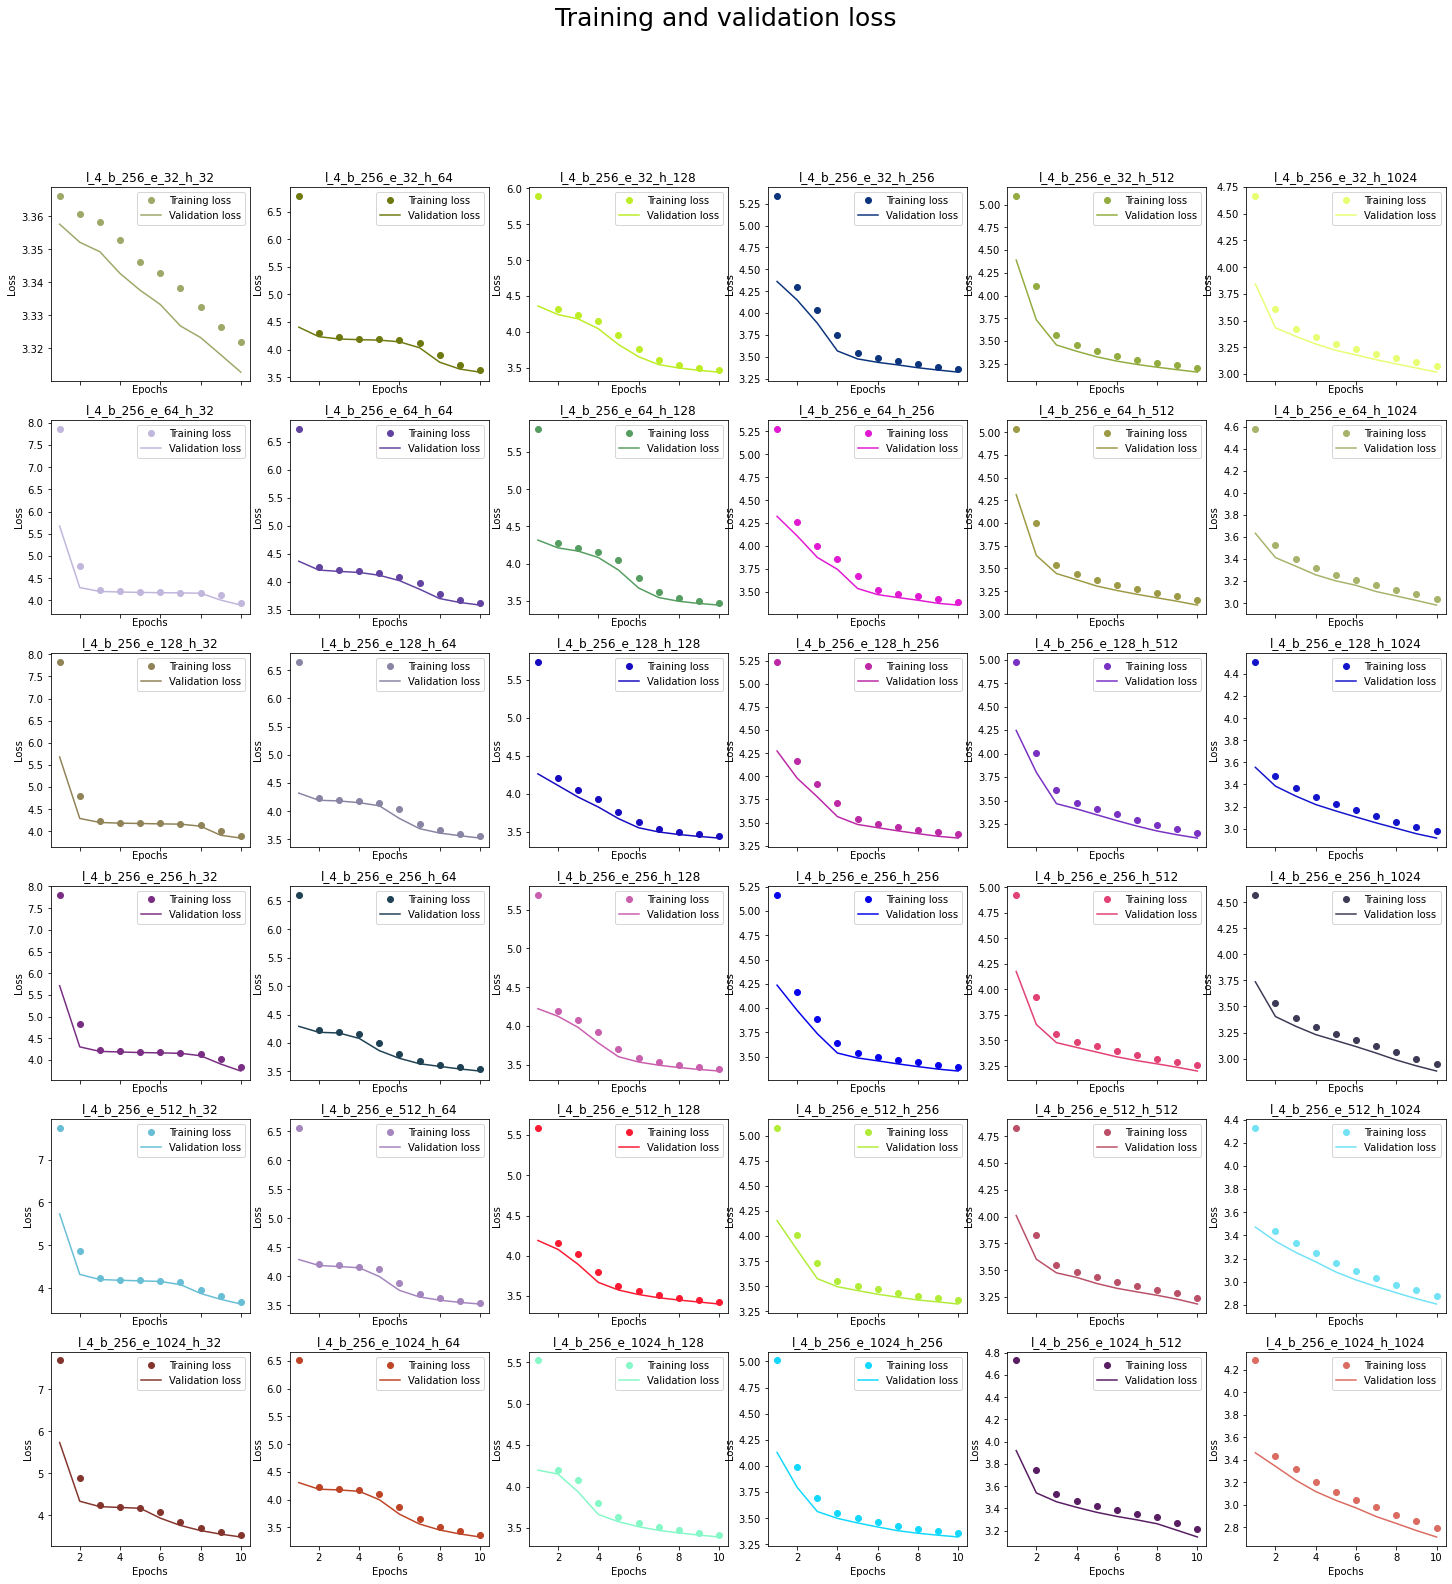

time: 6.32 s (started: 2021-02-02 20:56:49 +09:00)


In [19]:
import matplotlib.pyplot as plt
import numpy as np

figure, axes = plt.subplots(6, 6, sharex=True, figsize=(25,25))

x = range(1,11)
i = 0; j = 0
for name, history in histories.items():
    rgb = np.random.rand(3)
    axes[i][j].plot(x, history['loss'], c=rgb, marker='o', linestyle='', label='Training loss')
    axes[i][j].plot(x, history['val_loss'], c=rgb, label='Validation loss')
    axes[i][j].set_xlabel('Epochs')
    axes[i][j].set_ylabel('Loss')
    axes[i][j].set_title(name)
    axes[i][j].legend()
    if j == 5: i += 1; j = 0;
    else : j += 1
        
figure.suptitle('Training and validation loss', size=25)
figure.show()

- 그래프 분석
    - 그래프를 통하여 학습을 진행함에 따라 Training loss와 Validation loss가 어떻게 변화하는지 확인해 보았다.
    - 학습이 진행됨에 따라 두 값은 같은 경향을 띄며 감소하였다.
    - 비슷한 경향을 가지고 있으므로 overfitting은 발생하지 않았다고 볼 수 있다.
    - 하지만 Training loss와 Validation loss 사이에 적절한 격차가 확인되지 않아 underfitting이 되지 않았다고 확신할 수 없다는 문제가 남았다.

#### `val_loss`를 DataFrame로 출력
- DataFrame info
    - val_loss_df
        - column : embedding size
        - row : hidden size
    - val_loss_df_t
        - column : hidden size
        - row : embedding size

In [21]:
get_hidden_size = lambda name : name[name.index('h_')+2:]
get_embedding_size = lambda name : name[name.index('e_')+2:name.index('_h')]

time: 888 µs (started: 2021-02-02 20:57:09 +09:00)


In [22]:
range_steps = range(len(steps))
step_to_idx = {v:k for k, v in enumerate(steps)}
data = [[ [] for _ in range_steps] for _ in range_steps]
for key, val in histories.items():
    e = get_embedding_size(key)
    h = get_hidden_size(key)
    data[step_to_idx[int(e)]][step_to_idx[int(h)]] = val['val_loss'][-1]

time: 3.03 ms (started: 2021-02-02 20:57:09 +09:00)


In [23]:
import pandas as pd
val_loss_df = pd.DataFrame(data=data, columns=steps, index=steps)
val_loss_df

,32,64,128,256,512,1024
32,3.312780,3.591350,3.439827,3.324306,3.159061,3.017227
64,3.891880,3.581951,3.442652,3.356036,3.096538,2.982009
128,3.849028,3.522862,3.417316,3.332269,3.100798,2.914856
256,3.748119,3.508020,3.415952,3.350815,3.196754,2.880734
512,3.630559,3.524484,3.400604,3.324108,3.183743,2.807100
1024,3.481770,3.328482,3.391522,3.320641,3.144148,2.714461


time: 28.5 ms (started: 2021-02-02 20:57:10 +09:00)


In [24]:
val_loss_df_t = val_loss_df.transpose()
val_loss_df_t

,32,64,128,256,512,1024
32,3.312780,3.891880,3.849028,3.748119,3.630559,3.481770
64,3.591350,3.581951,3.522862,3.508020,3.524484,3.328482
128,3.439827,3.442652,3.417316,3.415952,3.400604,3.391522
256,3.324306,3.356036,3.332269,3.350815,3.324108,3.320641
512,3.159061,3.096538,3.100798,3.196754,3.183743,3.144148
1024,3.017227,2.982009,2.914856,2.880734,2.807100,2.714461


time: 20.9 ms (started: 2021-02-02 20:57:11 +09:00)


- DataFrame으로부터 가장 작은 Validation loss를 기록한 하이퍼 파라미터의 조합은 `embedding_size = 1024, hidden_size = 1024`이었다.

#### DataFrame 시각화

- 위에서 생성한 두개의 DataFrame을 box 그래프로 시각화하여 각 하이퍼 파라미터가 loss 값에 어떻게 영향을 미치고 있는지 경향성을 확인해 본다.

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


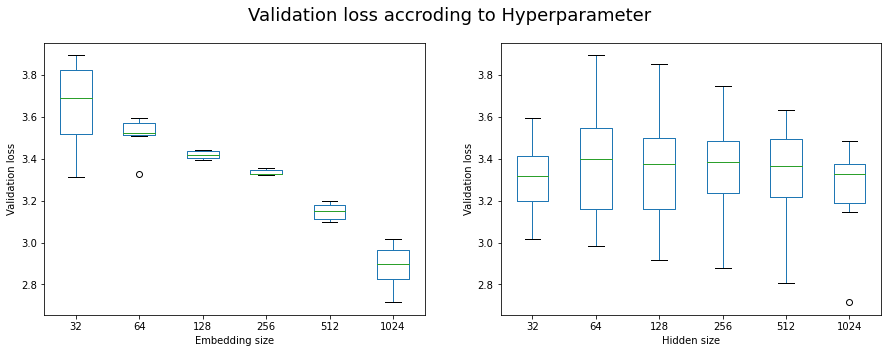

time: 276 ms (started: 2021-02-02 20:57:13 +09:00)


In [25]:
figure, axes = plt.subplots(1, 2, figsize=(15,5))
palette = ['r', 'orange', 'y', 'g', 'b', 'purple']

val_loss_df.plot.box(ax=axes[0])
axes[0].set_xlabel('Embedding size')
axes[0].set_ylabel('Validation loss')

val_loss_df_t.plot.box(ax=axes[1])
axes[1].set_xlabel('Hidden size')
axes[1].set_ylabel('Validation loss')

figure.suptitle('Validation loss accroding to Hyperparameter', fontsize=18)
figure.show()

- 두 그래프의 중앙값의 변화에서 확연하 차이를 보이고 있다.
    - Embedding size의 경우, size가 증가할수록 Validation loss가 확연하게 감소하는 경향을 관찰할 수 있다.
    - 반면, Hidden size가 변하여도 Validation loss의 중앙값은 3.2~3.4 사이에 머물며 큰 차이를 보이지 않는다.
    - 이를 통하여 32~1024 범위에서는 Embedding size가 Hidden size 보다 유의미한 변화를 만들어낸다는 것을 알 수 있었다.

#### 문장생성

In [26]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        
        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

time: 2.06 ms (started: 2021-02-02 20:57:16 +09:00)


In [27]:
init_sentences = [ "<start> i", "<start> i will", "<start> he", "<start> let", "<start> you", "<start> this"]
target = [ (i, 1024) for i in steps ]
model_names = [ get_model_name(4, hp) for hp in target ]
models = [tf.keras.models.load_model(get_model_path(4, hp)) for hp in target ]
sentences = []

for init_sentence in init_sentences:
    print("generate sentence >>>> " + init_sentence)
    tmp_sentences = [ generate_text(model, tokenizer, init_sentence=init_sentence) for model in models ]
    sentences.append(tmp_sentences)

generate sentence >>>> <start> i
generate sentence >>>> <start> i will
generate sentence >>>> <start> he
generate sentence >>>> <start> let
generate sentence >>>> <start> you
generate sentence >>>> <start> this
time: 29.5 s (started: 2021-02-02 20:57:17 +09:00)


In [28]:
for i, s in enumerate(sentences):
    print(f'init sentences :: {init_sentences[i]}')
    df = pd.DataFrame(data = s, columns=['generated sentence'], index=model_names)
    display(df)

init sentences :: <start> i


,generated sentence
l_4_b_256_e_32_h_1024,<start> i m a <unk> <end>
l_4_b_256_e_64_h_1024,<start> i m a <unk> <end>
l_4_b_256_e_128_h_1024,<start> i m a <unk> <end>
l_4_b_256_e_256_h_1024,<start> i m a <unk> <end>
l_4_b_256_e_512_h_1024,"<start> i m a <unk> , <end>"
l_4_b_256_e_1024_h_1024,<start> i m a <unk> <end>


init sentences :: <start> i will


,generated sentence
l_4_b_256_e_32_h_1024,<start> i will be a <unk> <end>
l_4_b_256_e_64_h_1024,<start> i will be a <unk> <end>
l_4_b_256_e_128_h_1024,<start> i will be a <unk> <end>
l_4_b_256_e_256_h_1024,<start> i will be a <unk> <end>
l_4_b_256_e_512_h_1024,<start> i will be a <unk> <end>
l_4_b_256_e_1024_h_1024,<start> i will be a <unk> <end>


init sentences :: <start> he


,generated sentence
l_4_b_256_e_32_h_1024,<start> he know i m a <unk> <end>
l_4_b_256_e_64_h_1024,<start> he know i m a <unk> <end>
l_4_b_256_e_128_h_1024,<start> he s a <unk> <end>
l_4_b_256_e_256_h_1024,<start> he s a <unk> <end>
l_4_b_256_e_512_h_1024,"<start> he s a <unk> , <end>"
l_4_b_256_e_1024_h_1024,<start> he s a <unk> <end>


init sentences :: <start> let


,generated sentence
l_4_b_256_e_32_h_1024,<start> let i m a <unk> <end>
l_4_b_256_e_64_h_1024,<start> let the <unk> <end>
l_4_b_256_e_128_h_1024,"<start> let the <unk> , i m a <unk> <end>"
l_4_b_256_e_256_h_1024,<start> let s a <unk> <end>
l_4_b_256_e_512_h_1024,<start> let s be a <unk> <end>
l_4_b_256_e_1024_h_1024,<start> let s be a <unk> <end>


init sentences :: <start> you


,generated sentence
l_4_b_256_e_32_h_1024,<start> you m a <unk> <end>
l_4_b_256_e_64_h_1024,<start> you re a <unk> <end>
l_4_b_256_e_128_h_1024,<start> you re a <unk> <end>
l_4_b_256_e_256_h_1024,<start> you re a <unk> <end>
l_4_b_256_e_512_h_1024,"<start> you re a <unk> , <end>"
l_4_b_256_e_1024_h_1024,<start> you re a <unk> <end>


init sentences :: <start> this


,generated sentence
l_4_b_256_e_32_h_1024,"<start> this <unk> , i m a <unk> <end>"
l_4_b_256_e_64_h_1024,"<start> this <unk> , i m a <unk> <end>"
l_4_b_256_e_128_h_1024,"<start> this <unk> , i m a <unk> <end>"
l_4_b_256_e_256_h_1024,<start> this s a <unk> <end>
l_4_b_256_e_512_h_1024,"<start> this <unk> , i m a <unk> <end>"
l_4_b_256_e_1024_h_1024,"<start> this <unk> , i m a <unk> <end>"


time: 25.4 ms (started: 2021-02-02 20:57:46 +09:00)


- 정말 놀랍게도 제대로 된 것이 하나도 없다!
- 추가적인 실험이 필요해 보인다!

## 추가실험
---

In [77]:
hyper_parm = [(512, 1024), (1024, 1024), (512, 2048)]

time: 1.16 ms (started: 2021-02-02 22:04:32 +09:00)


### 더 많은 데이터 - preprocessing 개선

- 이전에는 중복 문장을 preprocessing 과정에서 제거하였으나, 이를 살려 데이터의 양을 증가시켜 본다.

In [93]:
raw_corpus = load_sentences(WORKSPACE_PATH + '/data/lyrics/*')
raw_corpus_remove_blank = [ s for s in raw_corpus if len(s) > 0 and s != ' ' ]
corpus = preprocess_sentences(raw_corpus_remove_blank)  
print("after preprocessing : {}".format(len(corpus)))

after preprocessing : 156202
time: 1.63 s (started: 2021-02-02 23:03:18 +09:00)


In [94]:
tensor, tokenizer = tokenize(corpus)
vocab_size = tokenizer.num_words + 1
train_dataset, test_dataset = get_dataset(tensor, 256) 

Source Train: (124961, 14)
Target Train: (124961, 14)
Source Validation: (31241, 14)
Target Validation: (31241, 14)
time: 2.59 s (started: 2021-02-02 23:03:19 +09:00)


- 이전 실험에서의 수치에 비하면 데이터양이 많이 증가한 것을 확인할 수 있다.
    - Source Train: (78199, 14)
    - Target Train: (78199, 14)
    - Source Validation: (19550, 14)
    - Target Validation: (19550, 14)

- 모델 생성 및 학습 - 1

In [43]:
model_v2 = get_model(vocab_size, hyper_parm[0][0], hyper_parm[0][1], 4)
build_model(model_v2, input_sample) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 512)         6144512   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 1024)        6295552   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
dense_1 (Dense)              (None, None, 12001)       12301025  
Total params: 33,133,793
Trainable params: 33,133,793
Non-trainable params: 0
_________________________________________________________________
time: 4.59 s (started: 2021-02-02 21:11:04 +09:00)


In [46]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

model_v2.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history_v2 = model_v2.fit(train_dataset,
                          epochs=10,
                          validation_data=test_dataset)

Epoch 1/10
469/469 [==============================] - 91s 195ms/step - loss: 3.4047 - accuracy: 0.4997 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 89s 189ms/step - loss: 2.9167 - accuracy: 0.5374 - val_loss: 2.8467 - val_accuracy: 0.5439
Epoch 3/10
469/469 [==============================] - 89s 189ms/step - loss: 2.7445 - accuracy: 0.5478 - val_loss: 2.7291 - val_accuracy: 0.5526
Epoch 4/10
469/469 [==============================] - 90s 191ms/step - loss: 2.6090 - accuracy: 0.5571 - val_loss: 2.6462 - val_accuracy: 0.5601
Epoch 5/10
469/469 [==============================] - 90s 191ms/step - loss: 2.4905 - accuracy: 0.5660 - val_loss: 2.5769 - val_accuracy: 0.5672
Epoch 6/10
469/469 [==============================] - 89s 190ms/step - loss: 2.3812 - accuracy: 0.5755 - val_loss: 2.5215 - val_accuracy: 0.5747
Epoch 7/10
469/469 [==============================] - 89s 190ms/step - loss: 2.2784 - accuracy: 0.5858 - val_loss: 2.4739 

In [51]:
model_v2.save(f'{WORKSPACE_PATH}/models/v2/l_4_e_512_h_1024.h5' )

time: 735 ms (started: 2021-02-02 21:32:30 +09:00)


- 모델 생성 및 학습 - 2

In [48]:
model_v3 = get_model(vocab_size, hyper_parm[1][0], hyper_parm[1][1], 4)
build_model(model_v3, input_sample) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 1024)        12289024  
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
dense_2 (Dense)              (None, None, 12001)       12301025  
Total params: 41,375,457
Trainable params: 41,375,457
Non-trainable params: 0
_________________________________________________________________
time: 3.85 s (started: 2021-02-02 21:31:49 +09:00)


In [53]:
model_v3.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history_v3 = model_v3.fit(train_dataset,
                          epochs=10,
                          validation_data=test_dataset)

Epoch 1/10
469/469 [==============================] - 125s 266ms/step - loss: 3.0093 - accuracy: 0.5337 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 123s 262ms/step - loss: 2.8819 - accuracy: 0.5412 - val_loss: 2.8761 - val_accuracy: 0.5442
Epoch 3/10
469/469 [==============================] - 122s 260ms/step - loss: 2.8010 - accuracy: 0.5464 - val_loss: 2.8229 - val_accuracy: 0.5485
Epoch 4/10
469/469 [==============================] - 121s 259ms/step - loss: 2.7319 - accuracy: 0.5511 - val_loss: 2.7766 - val_accuracy: 0.5519
Epoch 5/10
469/469 [==============================] - 122s 261ms/step - loss: 2.6685 - accuracy: 0.5553 - val_loss: 2.7396 - val_accuracy: 0.5548
Epoch 6/10
469/469 [==============================] - 119s 254ms/step - loss: 2.6098 - accuracy: 0.5598 - val_loss: 2.7036 - val_accuracy: 0.5588
Epoch 7/10
469/469 [==============================] - 119s 253ms/step - loss: 2.5563 - accuracy: 0.5641 - val_loss: 

In [55]:
model_v3.save(f'{WORKSPACE_PATH}/models/v3/l_4_e_1024_h_1024.h5' )

time: 748 ms (started: 2021-02-02 21:55:39 +09:00)


### 더 큰 하이퍼 파라미터

In [78]:
model_v4 = get_model(vocab_size, hyper_parm[2][0], hyper_parm[2][1], 4)
build_model(model_v4, input_sample) 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 512)         6144512   
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 2048)        20979712  
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 2048)        33562624  
_________________________________________________________________
dense_4 (Dense)              (None, None, 12001)       24590049  
Total params: 85,276,897
Trainable params: 85,276,897
Non-trainable params: 0
_________________________________________________________________
time: 22.1 s (started: 2021-02-02 22:04:39 +09:00)


In [79]:
model_v4.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history_v4 = model_v4.fit(train_dataset,
                          epochs=10,
                          validation_data=test_dataset)

Epoch 1/10
469/469 [==============================] - 192s 410ms/step - loss: 3.7151 - accuracy: 0.4667 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 189s 403ms/step - loss: 3.3607 - accuracy: 0.5062 - val_loss: 3.3364 - val_accuracy: 0.5094
Epoch 3/10
469/469 [==============================] - 188s 402ms/step - loss: 3.2926 - accuracy: 0.5105 - val_loss: 3.2760 - val_accuracy: 0.5144
Epoch 4/10
469/469 [==============================] - 191s 408ms/step - loss: 3.2284 - accuracy: 0.5157 - val_loss: 3.2170 - val_accuracy: 0.5192
Epoch 5/10
469/469 [==============================] - 190s 405ms/step - loss: 3.1567 - accuracy: 0.5203 - val_loss: 3.1344 - val_accuracy: 0.5246
Epoch 6/10
469/469 [==============================] - 190s 404ms/step - loss: 3.0664 - accuracy: 0.5265 - val_loss: 3.0597 - val_accuracy: 0.5308
Epoch 7/10
469/469 [==============================] - 192s 410ms/step - loss: 3.0063 - accuracy: 0.5311 - val_loss: 

In [81]:
model_v4.save(f'{WORKSPACE_PATH}/models/v3/l_4_e_512_h_2048.h5' )

time: 1.67 s (started: 2021-02-02 22:39:12 +09:00)


### 평가

#### evaluation

In [72]:
def display_acc_loss_graph(history):
    x = range(1,11)
    
    figure, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))

    axes[0].plot(x, history['loss'], 'ro', label='Training loss')
    axes[0].plot(x, history['val_loss'], 'r', label='Validation loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and validation loss')
    axes[0].legend()
    
    axes[1].plot(x, history['accuracy'], 'bo', label='Training accuracy')
    axes[1].plot(x, history['val_accuracy'], 'b', label='Validation accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training and validation accuracy')
    axes[1].legend()

    figure.show()

time: 859 µs (started: 2021-02-02 22:02:35 +09:00)


In [60]:
def cal_loss(loss_list):
    _loss = []
    for loss_per_epochs in loss_list:
        loss_flatten = flatten(loss_per_epochs)
        loss = sum(loss_flatten) / len(loss_flatten)
        _loss.append(loss)
    return _loss

time: 484 µs (started: 2021-02-02 21:59:43 +09:00)


In [64]:
history_v2.history['loss'] = cal_loss(history_v2.history['loss'])
history_v2.history['val_loss'] = cal_loss(history_v2.history['val_loss'])

time: 28.5 ms (started: 2021-02-02 22:01:05 +09:00)


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


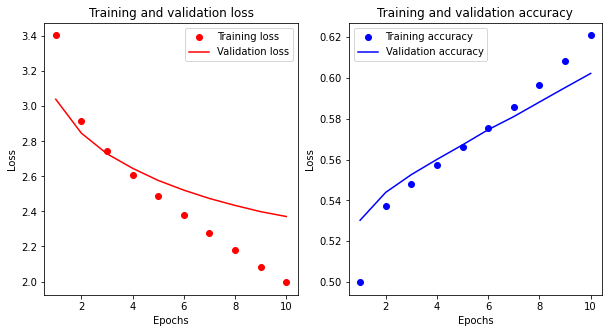

time: 217 ms (started: 2021-02-02 22:03:11 +09:00)


In [74]:
display_acc_loss_graph(history_v2.history)

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


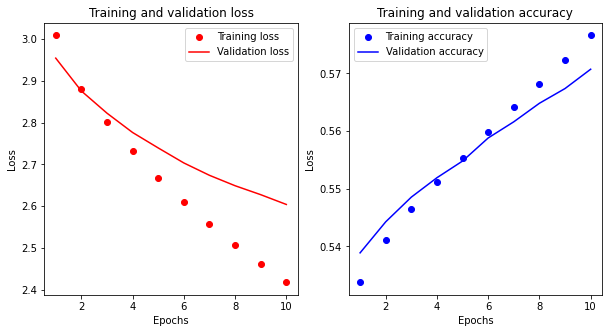

time: 285 ms (started: 2021-02-02 22:03:26 +09:00)


In [75]:
history_v3.history['loss'] = cal_loss(history_v3.history['loss'])
history_v3.history['val_loss'] = cal_loss(history_v3.history['val_loss'])
display_acc_loss_graph(history_v3.history)

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


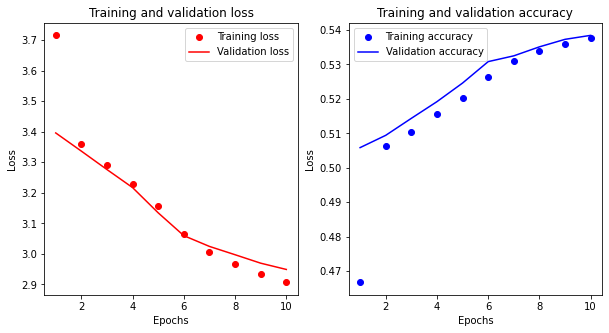

time: 278 ms (started: 2021-02-02 22:41:17 +09:00)


In [86]:
history_v4.history['loss'] = cal_loss(history_v4.history['loss'])
history_v4.history['val_loss'] = cal_loss(history_v4.history['val_loss'])
display_acc_loss_graph(history_v4.history)

#### 문장생성

In [82]:
init_sentences = [ "<start> i", "<start> i will", "<start> he", "<start> let", "<start> you", "<start> this"]
models = [ model_v2, model_v3, model_v4 ]
sentences = []

for init_sentence in init_sentences:
    print("generate sentence >>>> " + init_sentence)
    tmp_sentences = [ generate_text(model, tokenizer, init_sentence=init_sentence) for model in models ]
    sentences.append(tmp_sentences)

generate sentence >>>> <start> i
generate sentence >>>> <start> i will
generate sentence >>>> <start> he
generate sentence >>>> <start> let
generate sentence >>>> <start> you
generate sentence >>>> <start> this
time: 915 ms (started: 2021-02-02 22:39:38 +09:00)


In [84]:
for i, s in enumerate(sentences):
    print(f'init sentences :: {init_sentences[i]}')
    df = pd.DataFrame(data = s, columns=['generated sentence'], index=['v2', 'v3', 'v4'])
    display(df)

init sentences :: <start> i


,generated sentence
v2,"<start> i m a bad bitch , you know it <end>"
v3,<start> i m a survivor <end>
v4,<start> i m a <unk> <end>


init sentences :: <start> i will


,generated sentence
v2,<start> i will eat you alive <end>
v3,<start> i will not be a <unk> <end>
v4,<start> i will be a way <end>


init sentences :: <start> he


,generated sentence
v2,<start> he s a monster <end>
v3,"<start> he s a <unk> , <end>"
v4,<start> he s a <unk> <end>


init sentences :: <start> let


,generated sentence
v2,<start> let s go <end>
v3,<start> let s go <end>
v4,<start> let s be a way <end>


init sentences :: <start> you


,generated sentence
v2,<start> you re the only one that i m here <end>
v3,<start> you know that you re a <unk> <end>
v4,<start> you re a <unk> <end>


init sentences :: <start> this


,generated sentence
v2,<start> this is the last night <end>
v3,<start> this is the one that i m in the <unk> ...
v4,<start> this is a <unk> <end>


time: 41.7 ms (started: 2021-02-02 22:40:23 +09:00)


### 더 많은 학습

- epochs = 15 !

In [95]:
model_v5 = get_model(vocab_size, hyper_parm[0][0], hyper_parm[0][1], 4)
build_model(model_v5, input_sample) 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 512)         6144512   
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 1024)        6295552   
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 1024)        8392704   
_________________________________________________________________
dense_6 (Dense)              (None, None, 12001)       12301025  
Total params: 33,133,793
Trainable params: 33,133,793
Non-trainable params: 0
_________________________________________________________________
time: 3.35 s (started: 2021-02-02 23:04:41 +09:00)


In [98]:
history_v5 = model_v5.fit(train_dataset,
                          epochs=15,
                          validation_data=test_dataset)

Epoch 1/15
488/488 [==============================] - 89s 183ms/step - loss: 3.0899 - accuracy: 0.5256 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
488/488 [==============================] - 91s 187ms/step - loss: 2.7164 - accuracy: 0.5483 - val_loss: 2.7115 - val_accuracy: 0.5522
Epoch 3/15
488/488 [==============================] - 91s 187ms/step - loss: 2.5018 - accuracy: 0.5666 - val_loss: 2.5971 - val_accuracy: 0.5660
Epoch 4/15
488/488 [==============================] - 91s 186ms/step - loss: 2.3213 - accuracy: 0.5852 - val_loss: 2.5141 - val_accuracy: 0.5773
Epoch 5/15
488/488 [==============================] - 90s 184ms/step - loss: 2.1584 - accuracy: 0.6045 - val_loss: 2.4523 - val_accuracy: 0.5880
Epoch 6/15
488/488 [==============================] - 91s 186ms/step - loss: 2.0112 - accuracy: 0.6245 - val_loss: 2.4075 - val_accuracy: 0.5968
Epoch 7/15
488/488 [==============================] - 89s 183ms/step - loss: 1.8767 - accuracy: 0.6444 - val_loss: 2.3694 

- epoch가 12인 지점부터 overfitting이 발생함을 확인 할 수 있다.

## 결론
---

### 요약
- 목표 : 노래 가사 데이터를 학습하여 노래 가사를 생성하는 작문 인공지능을 구축해본다.
- 프로젝트 진행 과정
    - 데이터 전처리
        - 노래가사 데이터를 불러들여 모델이 학습할 수 있는 형태로 정제하였다.
        - 먼저, 빈 데이터를 제거하고 중복되는 문장을 제거하였다.
            - 처음 실험에서는 중복을 제거하였으나, 모델 학습결과 좋지 않았다. 상황을 개선하기 위하여 데이터의 수를 늘릴 필요가 있었고 중복제거 과정을 거치지 않는 것으로 데이터의 양을 확보하였다.
            - 실험결과 중복 문장을 제거하지 않고, 데이터를 수를 충분히 늘리는 것이 더 좋은 성능을 보여주었다.
        - 문장에서 작사에 필요하지 않은 특수문자를 제거하였다.
        - 너무 긴 문장을 생성하는 것은 이 단계에서는 어렵기 때문에 15 단어 이상으로 구성된 문장을 삭제하였다.
        - 토큰화를 진행하여 모델이 이해할 수 있는 형식으로 데이터를 변환하였다.
        - 전체 데이터의 80%를 훈련 데이터로 사용하기 위하여 분리하였고, 나머지 20%의 데이터를 테스트용으로 사용하였다.
    - 모델 생성, 학습
        - Embedding layer / LSTM layer / LSTM layer / Dense Layer로 구성된 모델을 설계하였고, 다양한 하이퍼 파라미터에 대한 모델을 생성하였다.
        - 생성된 모델들에 대한 학습을 진행하였고 이번 모델에 대해서는 embedding size가 성능에 많은 영향을 미침을 알 수 있었다.
    - 모델 평가
        - 최초에 설계된 프로젝트에 따른 모델의 성능의 몹시 좋지 못하였다. loss 값은 그럴듯 하였으나 실제 문장을 만드는 것에서는 완전한 문장을 만든 모델이 하나도 존재하지 않았다.
        - 이에 심신의 타격을 입어 추가 실험을 진행하였다.
    - 추가 실험
         - 위에서 언급한바와 같이 먼저 데이터 전처리 과정을 손대어 더 많은 양이 데이터를 확보하였다.
         - 이전 시험에서 사용한 것 보다 더 큰 하이퍼 파라미터 (518, 2048)를 사용하여 모델을 생성하였다.
         - 실험 결과, 데이터의 양을 충분히 확보하였을 때 더 좋은 성능을 보임을 확인할 수 있었다.
         - 이전 실험 최저 val_loss : 2.714461, 추가 실험 최저 val_loss : 2.3711 

### 프로젝트 평가

1. 가사 텍스트 생성 모델이 정상적으로 동작하는가? 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?
    - 가사 텍스트 생성 모델이 정상적으로 동작하였다.
    - 텍스트 제너레이션의 결과
        - "<start> you re the only one that i m here <end>"
        - "<start> this is the last night <end>"
        - "<start> i will eat you alive <end>"
        - "<start> he s a monster <end>"
        - "<start> i m a bad bitch , you know it <end>"
        - "<start> i m a survivor <end>"
        
2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가? 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
    - 데이터 전처리 : 빈 문자열 삭제, 15단어 이상으로 구성된 문장 삭제를 진행하였다. 중복 데이터를 제거하는 것과 제거하지 않는 것 두 가지 상황에 대하여 실험을 진행하였다.
    - 특수문자 제거 : `!`, `?`, `.`, `.`을 제외한 특수문자를 제거하는 작업을 진행하였다.
        - 문서에 남기지는 않았으나 1) `'`을 공백으로 대채한 경우 / 2) `'`를 제거하지 않고 하나의 단어로 인정한 경우 / 3) `'`를 붙어있는 문자와 함께 한 단어로 치는 경우(ex i'm)에 대해서도 각각 실험을 수행해 보았었다. 같은 하이퍼 파라미터로 테스트를 진행하였을 때 아예 제거하였을 때가 성능이 가장 좋았다. 노래 가사들이 구어체로 되어 있어 `'`을 사용하여 축약을 하는 단어가 데이터 상에 많이 존재하였다. 그렇기에 3)의 경우에는 너무 많은 단어가 생성되는 불상사가 발생하였고, 문장을 생성하였을 때, 아예 문장이 생성되지 않는 경우가 많았다. 가사 내에서 `'`의 사용빈도가 높기 때문인지 2)의 경우에는 \<start> i ' ' ' ' '  같은 문장이 생성되기도 하였다.
    - 토크나이저 생성 : 토큰화 과정을 정상적으로 수행하였다.
    - 패딩처리 : post padding을 진행해주었다.

3. 텍스트 생성모델이 안정적으로 학습되었는가? 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?
    - 모델이 안정적으로 학습되었다.
    - 모델의 최저 validation loss는 2.3711로 안타깝게도 2.2 이하로 떨어지 못했다.

### 회고

- 프로젝트에 투자한 순수한 시간이 가장 긴 노드였다. 설계 방향이 잘 못되어, 헛되게 쓴 시간이 많았고(다양한 하이퍼 파라미터에 대한 시도) 코드 상으로 잡음이 많았었으며, 그럼에도 원래 계획에 절반 정도 밖에 해내지 못하였다.
- 잘못된 프로젝트 설계
    - 이번 프로젝트를 수행하는 과정에서 초기에는 아주 쉬운 난이도라 생각하여, 평소에 궁금하게 생각하였던 하이퍼 파라미터의 선택에 따른 성능 변화가 얼마나 큰가에 대해서 실험해 보고자 32~1024 범위에서 값을 변경시켜가며 실험을 진행하였다. 실험을 마치고 이것이 잘못된 설계였다고 판단한 근거는 추가실험의 v2, v3 모델의 평가 결과이다. 이론상 embedding size와 hidden size는 크기에 따른 모델의 성능은 점점 좋아지다가 어느 순간을 기점으로 퇴화해야한다. 다양한 하이퍼 파라미터를 지정한 이유도 이 현상을 관찰하고 싶었기 때문이다.하지만, 본 실험에서는 성능이 좋아지기만 할 뿐, 나빠질 기미조차 보이지 않았다. 반면 추가실험에서는 (512, 1024)에서의 성능보다 (1024, 1024)의 성능이 더 좋지 않은 것이 관찰되었다.
    - 이것으로 알 수 있었던 설계의 실패 포인트는 실험의 순서였다. 목표하는 모델에 가장 최적화된 하이퍼 파라매터를 먼저 찾고 그것을 활용하여 전처리에 따른 성능변화나 네트워크 구조에 따른 성능변화를 관찰하려던 것이 최초의 설계였다. 하지만 이번 프로젝트는 통해서 제대로 정제된 데이터가 없는 상태에서는 모델이 제대로 학습되지 않이 때문에 그 상태에서 다양한 하이퍼 파라미터를 투입하여 실험을 하고 변화를 관찰하여도 사실상 아무 의미가 없음을 알게 되었다.
- 원계획 :  프로젝트의 초기 단계에서 할만한데?-라고 쉼게 생각하여 넘치는 야망으로 설계하였으나 수행하지 못한 단계들이 남아있다. 이곳에 표지판처럼 기록해 두고 차후에 돌아와서 다시 수행해보고자 한다.
    - pre padding vs post padding : ref 첫번째에 해당하는 논문에 따르면 대다수의 경우 pre-padding 방식이 post-padding 방식보다 더 좋은 성능을 보여 준다. 하지만, 직관적으로 생각하였을 때, 이번 프로젝트는 문장의 앞부부에 중요한 정보가 있기 때문에 pre-padding을 하는 것이 더 유리해 보인다. 실제로 이번 프로젝트에 한하여 pre-padding과 post-padding 중 어느 방법이 더 좋은 성능을 보일까? 만약 pre-padding이 더 좋은 성능을 보인다면, pre-padding이 post-padding을 이길 수 있는 다른 사례는 어떤 것이 있을까?
    - 학습된 모델을 저장하는 다양한 방법 : 이번 프로젝트에서는 많은 모델을 생성하였고, 단일 모델에 대한 학습시간이 조금 걸리는 편이므로 모델을 저장하고 불러와 사용하는 경우가 많았다. 그 과정에서 모델이 상당히 많은 용량을 차지하는 것을 알게되었다. 지금 이 글을 작성하는 순간의 모델 저장 디렉토리의 용량은 무려 14.8GB이다. h5 방식으로 모델을 저장하고 있는데, 이것보다 더 가벼운 방식은 없을까?
    - 노드에서는 `tf.keras.Model`을 super class로 가져와서 `TextGenerator`를 만들고 있다. `tf.keras.Model`을 이용하여 모델 클래스를 생성하였을 때의 장점과 클래스 작성 방식에 대해 알아보자.
    - 이전 프로젝트에서 사전 학습된 워드 임베딩을 사용하면 모델의 성능을 올릴 수 있다고 배운바있다. 학습된 word2vec를 모델에 도입하여 성능 차이를 확인해 보자. 더하여 인터넷 서치결과 구어체를 학습한 word2vec, 위키피디아를 학습한 word2vec, 뉴스 정보를 학습한 word2vec 등 영어 word2vec는 다양한 리소를 기반으로 학습된 다양한 버전이 많은 것을 확인할 수 있었다. word2vec가 학습한 데이터의 종류에 따라서 같은 TextGenerator가 생성하는 문장도 달라지를 확인해 보는 것도 재밋는 실험이 될 것이다.
    - 실험의 편의성을 위하여 필요한 부분에 코드를 작성하였더니 문서가 너무 산만하다. 적절히 리팩토링하여 코드를 Code Collection 안으로 수납하자.

In [101]:
!du -sh ./models

14G	./models
time: 210 ms (started: 2021-02-02 23:50:35 +09:00)


## Code Collection
---

#### 데이터 읽어들이기 : `load_sentences`

In [31]:
def load_sentences(path):
    txt_list = glob.glob(path)
    raw_corpus = []

    # 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
    for txt_file in txt_list:
        with open(txt_file, "r") as f:
            raw = f.read().splitlines()
            raw_corpus.extend(raw)

    return raw_corpus

time: 1.18 ms (started: 2021-02-02 21:02:38 +09:00)


### ref
- [pre pedding vs post pedding](https://arxiv.org/pdf/1903.07288.pdf)
- [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
- [학습 모델 보기/저장하기/불러오기](https://tykimos.github.io/2017/06/10/Model_Save_Load/)